# DeepFeature: DeepInsight CAM-based Feature Selection Example

This example shows a case of using class activation maps (CAMs) and a trained model to identify important features in class prediction as proposed in *[DeepFeature: feature selection in nonimage data using convolutional neural network](https://doi.org/10.1093/bib/bbab297)*. The first three sections are the similar to steps taken in the [pyTorch SqueezeNet example](./pytorch_squeezenet.ipynb). Please see that example for a fuller explaination of these steps. 

### Jump to section
* [TCGA RNASeq2GeneNorm data](#tcga-rnaseq2genenorm-data)
* [DeepInsight Image Transformation](#deepinsight-image-transformation)
* [CNN Image Classification](#cnn-image-classification)
* **[DeepFeature CAM-based Feature Selection](#deepfeature-cam-based-feature-selection)**
    * [Step 1 - CAMFeatureSelector Object](#step-1---camfeatureselector-object)
    * [Step 2 - Compute Class-Specific CAMs](#step-2---compute-class-specific-cams)
    * [Step 3 - Select Class-Specific Features](#step-3---select-class-specific-features)
    * [Step 4 - Extract Feature Names](#step-4---extract-feature-names)
    * [Tuning Feature Count](#tuning-feature-count)
        * [CAM Flattening Method](#cam-flattening-method)
        * [Activation Threshold](#activation-threshold)

In [1]:
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output

2024-04-11 08:33:13.384900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 08:33:13.384974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 08:33:13.386064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 08:33:13.392443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 08:33:14.194478: W tensorflow/compiler/tf2

## TCGA RNASeq2GeneNorm data

Here we load the TCGA primary tumor RNASeq data for 8 cancer types as described in the data [README.md](./data/README.md#curatedTCGAData_RNASeq2GeneNorm-20160128)

In [2]:
expr_file = r"./data/curatedTCGAData_RNASeq2GeneNorm-20160128.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
genes = expr.iloc[:, 2:].columns.to_numpy()

random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

Remove low variance data. In this case the bottom 30%.

In [3]:
var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

Scale the data to between 0 and 1

In [4]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])

Encode the classes

In [5]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [6]:
reducer = umap.UMAP(
    n_components=2,
    #min_dist=0.8,
    metric='cosine',
    n_jobs=-1
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

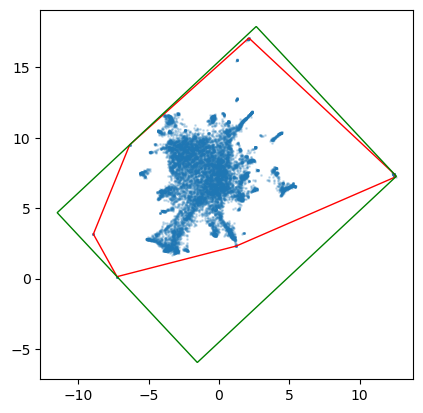

In [7]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

## CNN Image Classification
Train ResNet50 CNN

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

In [10]:
batch_size=50
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), 
    lr=1e-02,
    momentum=0.9,
)

In [12]:
net.train()
for epoch in range(20):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

'Epoch 019, batch 072'

In [13]:
test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")

The test accuracy was 0.968


## DeepFeature: CAM-based Feature Selection

The feature selection method uses the class activation maps of all samples in a class to identify important features for differenting classes. The DeepInsight CAM-base feature selection is done in 3 steps.

### Step 1 - CAMFeatureSelector object
Create the `CAMFeatureSelector` object. This class must be provided with the previously constructed DeepInsight `ImageTransformer` object and the CNN model trained using the output of that object. In addition, there are two optional parameters: 

* target_layer: the layer of the CNN model to use to compute the CAM. This can be the name of the layer or the layer itself. If none is given, CAMFeatureSelector will choose an appropriate layer using methods from the package [torchcam](https://github.com/frgfm/torch-cam).
* cam_method: name of the CAM method from the package [grad-cam](https://github.com/jacobgil/pytorch-grad-cam). The default is "GradCAM".

In [14]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

### Step 2 - Compute Class-Specific CAMs
Calculate the CAM for each input image and then combine into a single CAM for each class via the given method. 'Mean' returns the mean of each pixel across all inputs of a class, 'max' returns the maximum value observed for each pixel and acts as the union, and 'min' returns the minimum value observed for each pixel and acts as the intersect. Batch size can be provided to optimize speed versus memory usage.

In [15]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

### Step 3 - Select Class-Specific Features
Feature selection for each class is performed by identifying feature indicies mapped to coordinates of the CAM that pass the threshold.

In [16]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

An image representing the CAM can be generated using [pytorch_grad_cam](https://github.com/jacobgil/pytorch-grad-cam) `show_cam_on_image()` and [Matplotlib](https://matplotlib.org/).

In [17]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

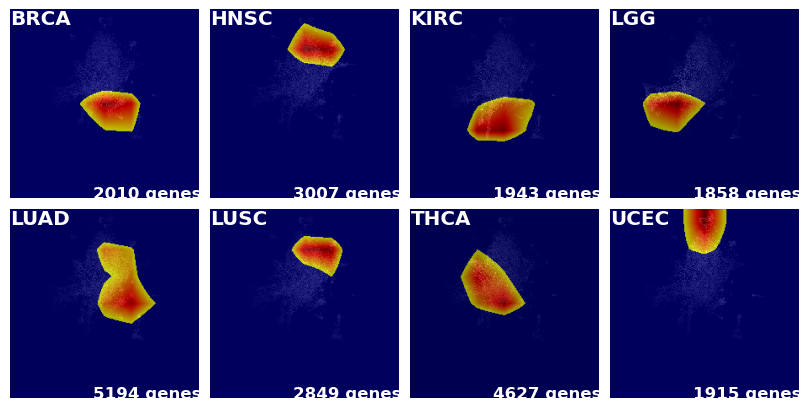

In [18]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

### Step 4 - Extract Feature Names
From this a list of selected features for each class can be extracted.

In [19]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")

 2010 features selected for BRCA: NAA50, NOG, NPFF, PSMB11, KAT2B, IP6K1, LRRC70, MAP1S, PRDM16...
 3007 features selected for HNSC: FXYD7, PRR13, ANKRD56, C12orf39, C9orf171, DPYD, GAL, GGT6, GPR180...
 1943 features selected for KIRC: CCL22, CYP2C9, PARP8, POT1, ARL5A, GINS2, NBR2, PLD4, COASY...
 1858 features selected for LGG : GPC3, ITPRIPL1, NEK2, OPHN1, HRASLS2, AGPAT1, HES2, C15orf29, C17orf66...
 5194 features selected for LUAD: DDOST, IGF2BP3, INO80E, LOC100130872, LOC729603, C1orf84, CKAP4, AP1M2, MESDC2...
 2849 features selected for LUSC: GUSBP1, C10orf90, IP6K2, MIER1, AKAP7, EPS8L2, MAN1B1, LMAN1L, PES1...
 4627 features selected for THCA: DGKQ, CSTF2T, FBP2, KLRD1, COX17, PRKCA, MEGF9, EPCAM, IMPA2...
 1915 features selected for UCEC: DNAH14, NRIP3, NRK, NRL, CYFIP1, FRMPD2, FRMPD4, FRS2, FRS3...


Or examine the number of shared genes selected for each class

In [20]:
feat = pd.DataFrame()
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    feat = pd.concat([feat, pd.DataFrame({'cancer':le_mapping[cat], 'gene':feature_names})])
fdf = feat.assign(selected=1).pivot(index='cancer', columns='gene', values="selected").fillna(0).astype(int)

pd.DataFrame(
    np.matmul(fdf.values,fdf.T.values),
    index=fdf.index.values,
    columns=fdf.index.values
)

,BRCA,HNSC,KIRC,LGG,LUAD,LUSC,THCA,UCEC
BRCA,2010,0,1316,450,1496,0,1485,0
HNSC,0,3007,0,0,1639,2475,0,1468
KIRC,1316,0,1943,666,986,0,933,0
LGG,450,0,666,1858,76,0,667,0
LUAD,1496,1639,986,76,5194,1985,1504,553
LUSC,0,2475,0,0,1985,2849,0,1017
THCA,1485,0,933,667,1504,0,4627,0
UCEC,0,1468,0,0,553,1017,0,1915


### Tuning Feature Count

#### CAM Flattening Method

##### flatten_method="max"
As the max CAM value is selected for each pixel, this selects all features that passed threshold in *any* member of the class - in essence a union of all features that passed the threshold for any individual samples of a class. This will select more features with a broader relationship to class prediction.

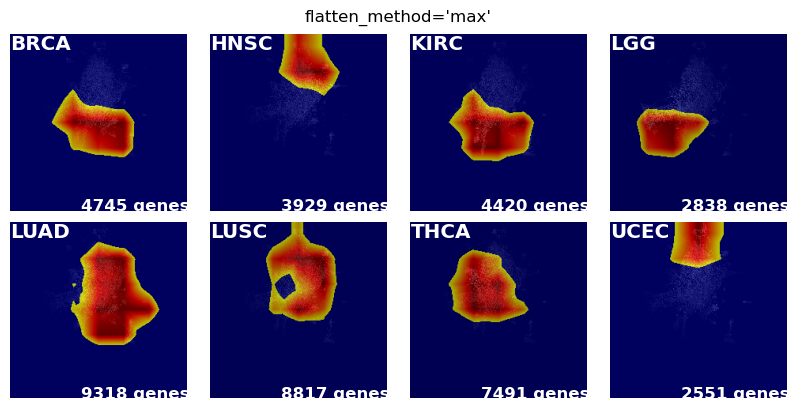

In [21]:
fl_method = 'max'

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}'")
plt.show()

##### flatten_method="min"
As the min CAM value is selected for each pixel, this selects only features that passed threshold in *all* members of the class - in essence a intesect of features that passed the threshold for all individual samples of a class. This will select less features with a stronger relationship to class prediction.

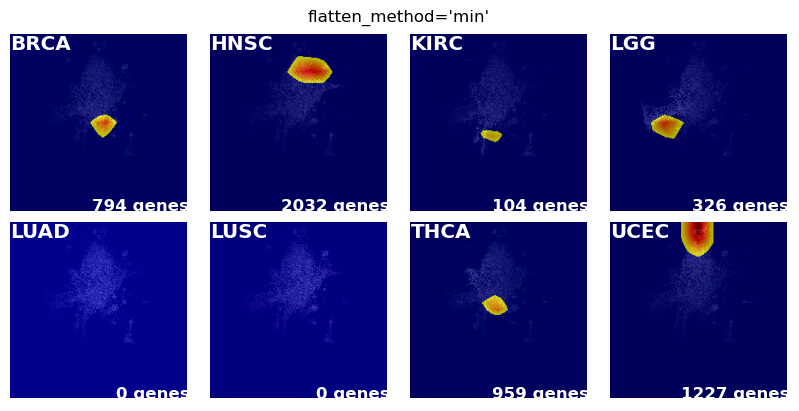

In [22]:
fl_method = 'min'

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}'")
plt.show()

#### Activation Threshold

Another way to alter the number of features selected is to change the CAM threshold at which features are selected.

Let's once again use 'mean' as the flattening method.

In [23]:
fl_method = 'mean'
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

##### threshold=0.9
A higher threshold will select less features.

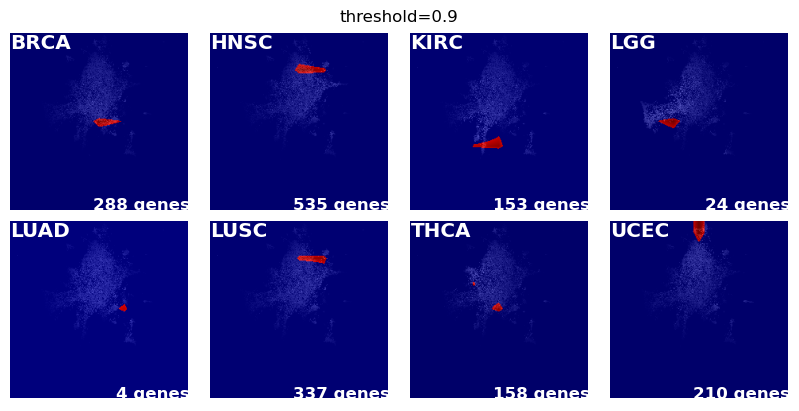

In [24]:
fs_threshold=0.9

feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"threshold={fs_threshold}")
plt.show()

##### threshold=0.3
A lower threshold will select more features.

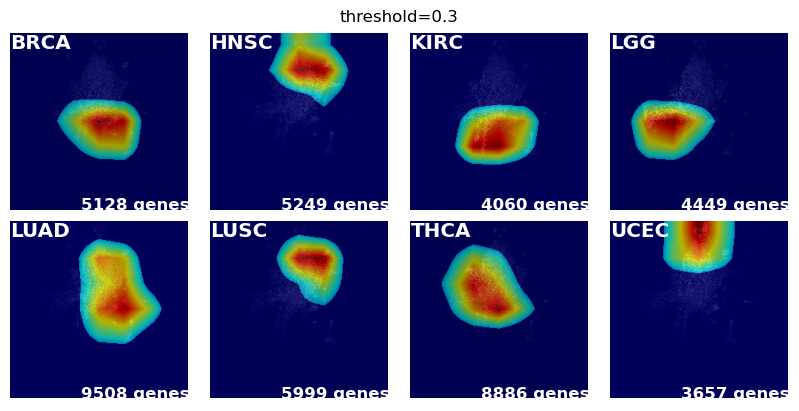

In [25]:
fs_threshold=0.3

feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"threshold={fs_threshold}")
plt.show()

#### Combining flattening method and threshold 

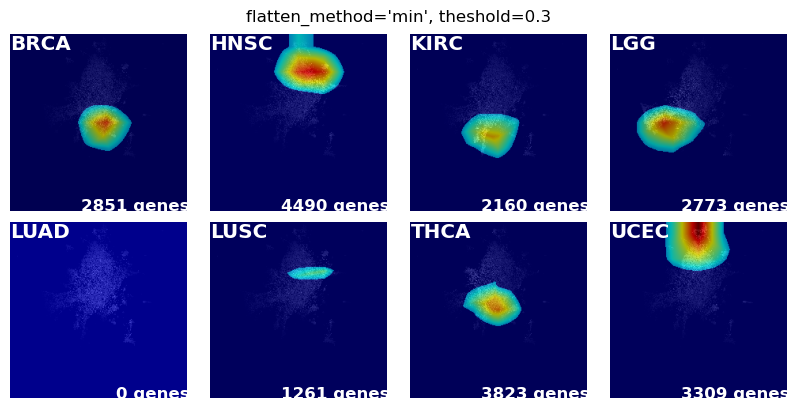

In [26]:
fl_method = 'min'
fs_threshold = 0.3

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}', theshold={fs_threshold}")
plt.show()